# Decision Trees and Random Forests: Application on feature data for HeLa cell line in GREG.

### Author : Shaurya Jauhari (Email: shauryajauhari@gzhmu.edu.cn)
### Last Reviewed : December 15th 2020

## Background

This notebook assesses variaegated implementations of the random forest models for the data dervied from the HeLa cell-line in GREG. The data for the same and other cell-types for GREG is available at this <a href = "https://zenodo.org/deposit/4265559"> link</a>.

## Contents

* [1. Decision Trees](#link1)
    * [1.1 Package Installation and Loading Libraries](#link2)
    * [1.2 Dataset Handling](#link3)
    * [1.3 Deploying Tree Models](#link4)
        * [1.3.1 'party' Package](#link5)
            * [1.3.1.1 SMOTE Transformation](#link6)
        * [1.3.2 'rpart' Package](#link7)
* [2. Random Forests](#link8)
    * [2.1  Core (randomForest)](#link9)
* [3. Visualizing Predictions](#link10)
* [4. Session Information](#link11)

##  <a id=link1>1. Decision Trees </a>

### <a id=link2>1.1 Package Installation and Loading Libraries </a>

In [1]:
requiredPackages <- c("party", "rpart", "rpart.plot", "ROSE", "DMwR", "randomForest")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages,
                                         repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/",
                                         dependencies = TRUE)

suppressPackageStartupMessages(library(party))
suppressPackageStartupMessages(library(rpart))
suppressPackageStartupMessages(library(rpart.plot))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(ggplot2))

### <a id=link3>1.2 Dataset Handling </a>

In [2]:
helagregStandard <- read.table("../../transcriptionFactoriesGREG/MachineLearning/data/HeLaforML.txt", header = TRUE) ## loading data
helagreg <- helagregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(helagreg)

CTCF     EP300     H3K27me3  H3K36me3  H3K4me1   H3K4me2   H3K4me3   H3K9ac  
1  0.00000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.000000
2  0.00000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.000000
3  0.00000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.000000
4  0.00000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.000000
5  0.00000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.000000
6 16.31532 0.3485739 0.7310137 0.5121474 0.2671445 0.9937343 0.8823614 1.233227
  H3K9me3    RAD21      RNA.Seq RNAPol2  RNAPol3     Class  
1 0.00000000 0.00000000 0       0.000000  0.00000000 Non-Hub
2 0.00000000 0.00000000 0       0.000000  0.00000000 Non-Hub
3 0.00000000 0.00000000 0       0.000000  0.00000000 Non-Hub
4 0.00000000 0.00000000 0       0.000000  0.00000000 Non-Hub
5 0.00000000 0.00000000 0       0.000000  0.07964071 Non-Hub
6 0.03706458 0.08740367 0       1.506197 13.00798194 Non-Hub

In [4]:
rownames(helagreg) <- c()
helagreg$Class <- as.numeric(as.factor(helagreg$Class))
helagreg$Class <- ifelse(helagreg$Class == 2, 0, 1)
head(helagreg$Class)

[1] 0 0 0 0 0 0

### <a id=link4>1.3 Deploying Tree Models </a>

#### <a id=link5>1.3.1 'party' Package </a>

Let us now partition the data into training and testing subsets, as per the Pareto's dogma, i.e. maintaining 80:20 ratio for train and testing cases.

In [5]:
set.seed(3)
dataPartition <- sample(2, nrow(helagreg), replace = TRUE, prob = c(0.8,0.2))
train <- helagreg[dataPartition==1,]
test <- helagreg[dataPartition==2,]

In [6]:
cat("We have",nrow(train),"training examples and",nrow(test),"for testing.")

We have 1214551 training examples and 304375 for testing.

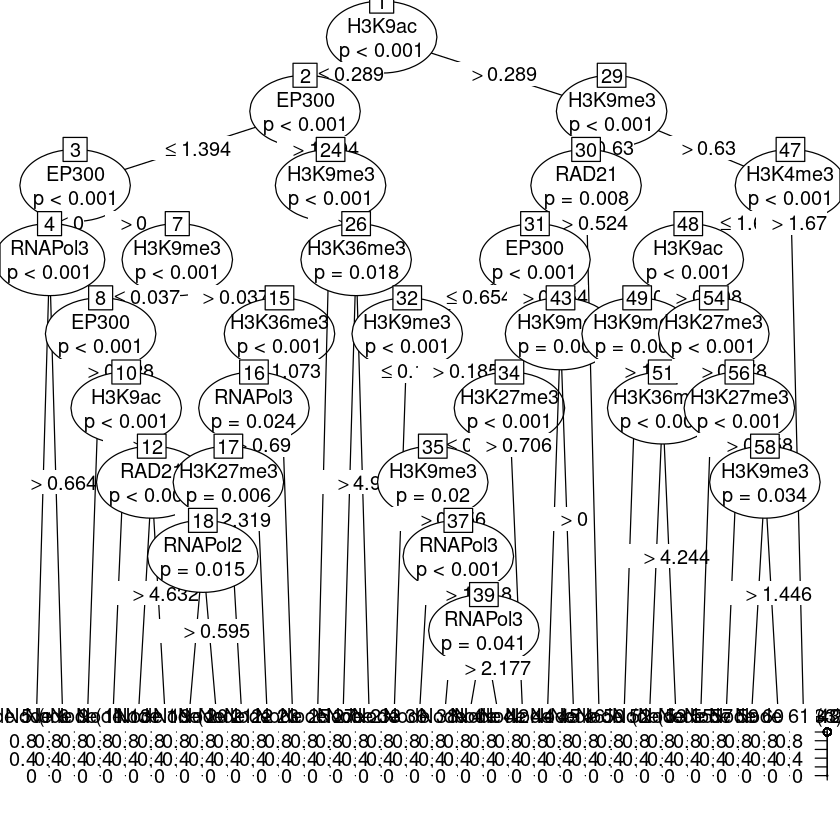

In [7]:
helaTree <- ctree(Class ~ ., data= train)
plot(helaTree)

The summary says that the tree has 61 overall nodes.

In [8]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(helaTree, "rf", test, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 303911    464
The accuracy of the model is 99.84756 % 
The misclassification error of the model is 0.1524435 % 


[1] "Only a single class predicted. Probably skewed data handling."

In [9]:
treePred <- predict(helaTree,test)
head(ifelse(treePred > 0.5, "Hub", "Non-Hub"))
treePred <- ifelse(treePred > 0.5, "1", "0")

Class  
[1,] Non-Hub
[2,] Non-Hub
[3,] Non-Hub
[4,] Non-Hub
[5,] Non-Hub
[6,] Non-Hub

In [10]:
treePredProb <- predict(helaTree,test, type="prob")
head(treePredProb)

[[1]]
[1] 0

[[2]]
[1] 0.001119865

[[3]]
[1] 0.001119865

[[4]]
[1] 0.001119865

[[5]]
[1] 0.001119865

[[6]]
[1] 0.001119865

It can be articulated that the high skewness in data towards "Non-Hubs" outnumbering "Hubs" has engenedered a high-probability of classification for the former and "Hubs" haven't been predicted at all. 

Let us examine if the bifurcation of data into 7:3 ratio of training and testing sets makes any difference in the structure of the classification tree here.

In [11]:
set.seed(03)
dataPartition73 <- sample(2, nrow(helagreg), replace = TRUE, prob = c(0.7,0.3))
train73 <- helagreg[dataPartition73==1,]
test73 <- helagreg[dataPartition73==2,]

In [12]:
cat("We have",nrow(train73),"training examples and",nrow(test73),"for testing.")

We have 1062981 training examples and 455945 for testing.

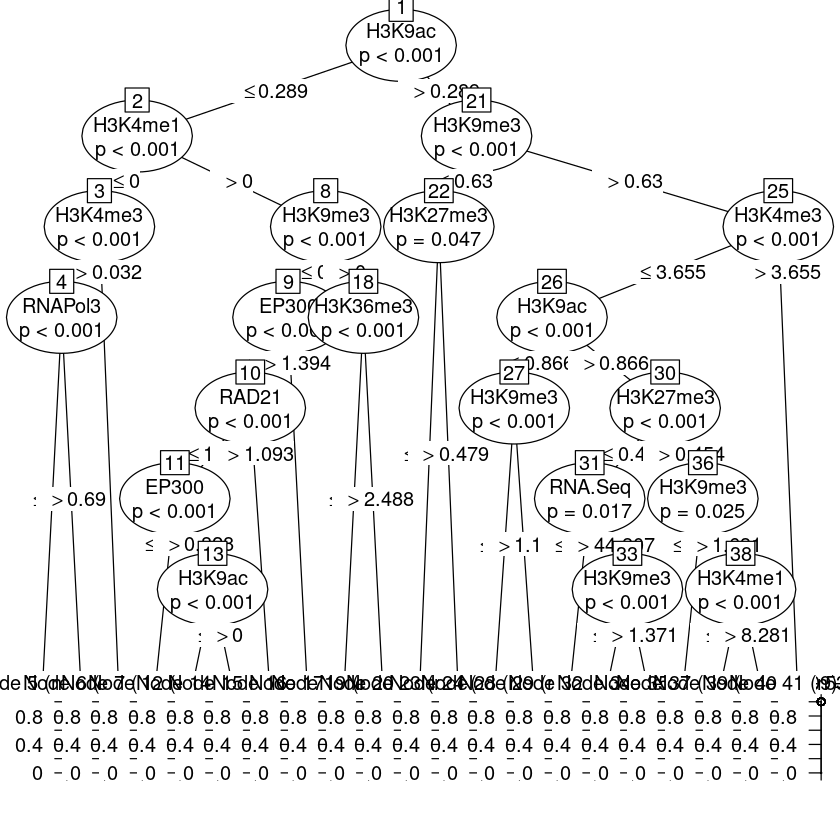

In [13]:
helaTree73 <- ctree(Class ~ ., data= train73)
plot(helaTree73)

In [14]:
treePred73 <- predict(helaTree73, test73, type="response")
treePred73 <- ifelse(treePred73 > 0.5, "1", "0")

In [15]:
modelPerformance(helaTree73, "rf", test73, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 455234    711
The accuracy of the model is 99.84406 % 
The misclassification error of the model is 0.1559399 % 


[1] "Only a single class predicted. Probably skewed data handling."

No luck here too. The data is highly biased, even for the modified data split. Let's resort to SMOTE transformation.

##### <a id=link6>1.3.1.1 SMOTE Transformation </a>

SMOTE transformation of the data has engendered fair model performance, in the case of logistic regression. See the pipeline [here](https://nbviewer.jupyter.org/github/shauryajauhari/transcriptionFactoriesGREG/blob/master/MachineLearning/LogisticRegressionA549GREG.ipynb).

In [16]:
train$Class <- as.factor(train$Class)
set.seed(77)
smoteData <- SMOTE(Class ~., train, perc.over = 1000, k = 5, perc.under = 110)
table(smoteData$Class)


    0     1 
20262 20262 

Now that the data is seemingly balanced, let's examine the performance of the model.

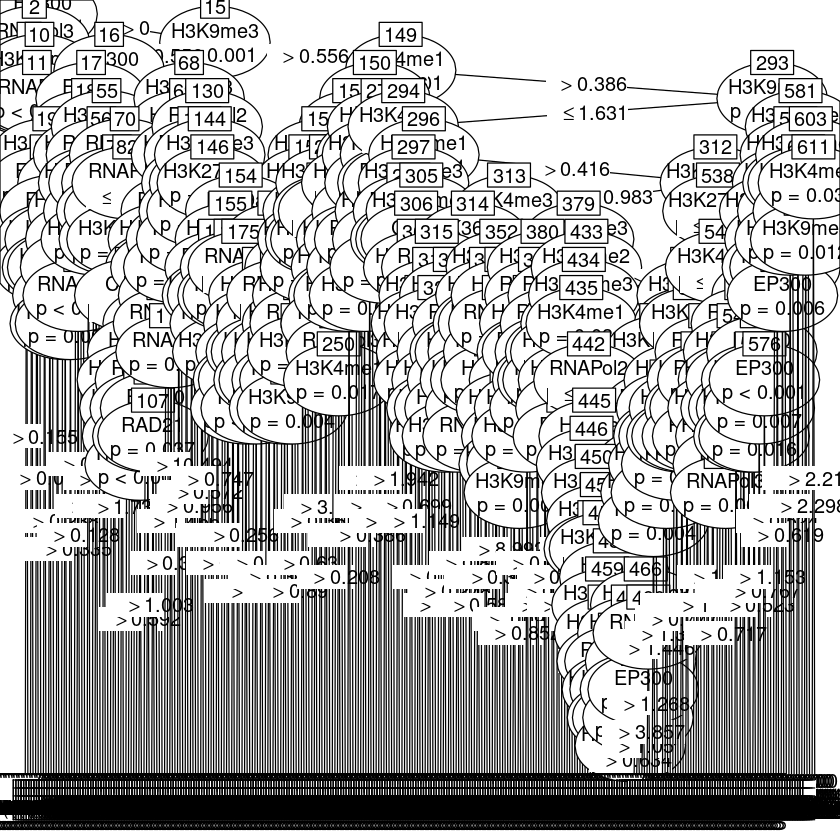

In [17]:
helaSmoteTree <- ctree(Class ~ ., data= smoteData)
plot(helaSmoteTree)

Apparently, the stablization of the class distribution in the data has made the tree more comprehensive. 

Obviously, it is hard to interpret the graphic above.

In [18]:
treeSmotePred <- predict(helaSmoteTree, test)
head(treeSmotePred)

[1] 0 0 0 0 0 0
Levels: 0 1

The confusion matrix is
         Actual
Predicted      0      1
        0 207616    163
        1  96295    301
The accuracy of the model is 68.30949 % 
The misclassification error of the model is 31.69051 % 
The sensitivity of the model is 68.31474 % 
The specificity of the model is 64.87069 % 
The area under curve is 0.6659271 



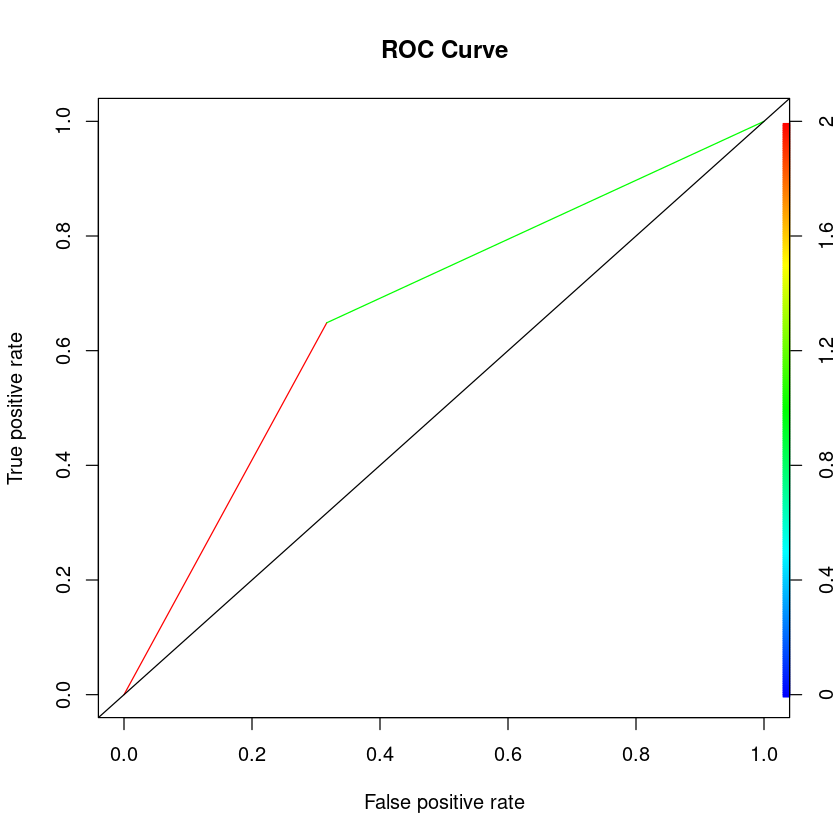

In [19]:
modelPerformance(helaSmoteTree, "rf", test, Class)

We can see distinct class indulgences, as opposed to the above cases of just "Non-Hub" instances.

The AUC and accuracy are pretty darn fair. Also, a notable observation is that the sensitivity and specificity are well balanced. Maybe, we should explore other options.

Addtionally, the function ctree() offers flexibility in terms of defining parameters for classification via ctree_control() function. Look for attributes *mincriterion* and *minsplit*. The former denotes the confidence level (i.e. 1- probability value), while the latter signifies the minimum number of samples required for splitting a tree branch into two. The default values are 0.95 and 20 respectively. Let us examine if any alteration makes a difference.They can be accessed via *controls*, i.e. ctree(formula,data,controls=ctree_control(mincriterion= , minsplit= ).


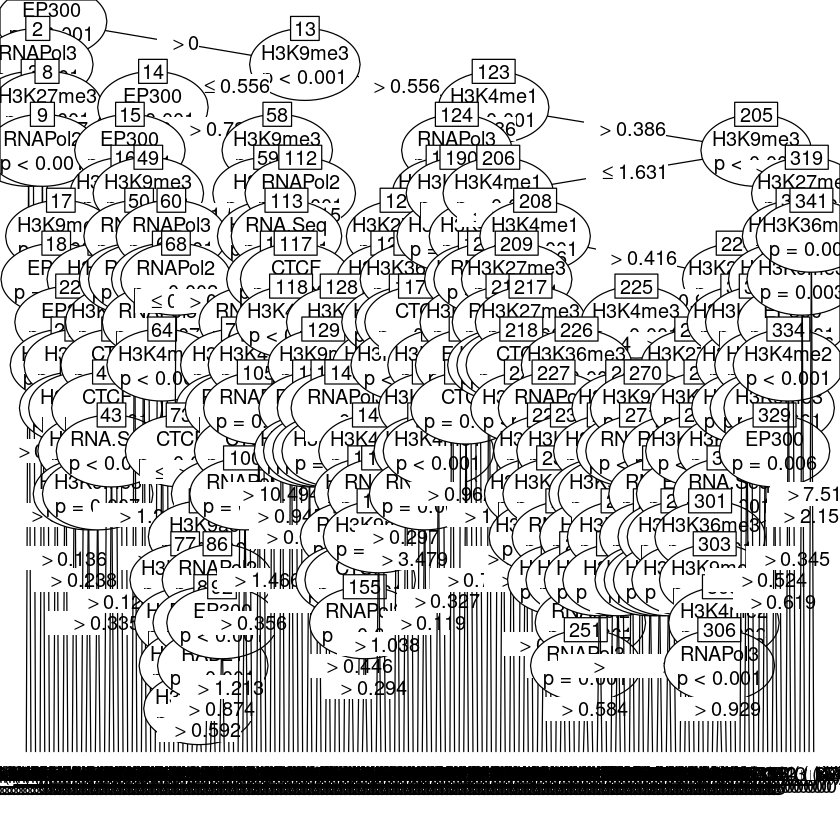

In [20]:
helaSmoteTreeAlt <- ctree(Class ~ ., data= smoteData, controls=ctree_control(mincriterion = .99, minsplit= 10))
plot(helaSmoteTreeAlt)

This tree has relatively lesser number of nodes as more stringent criteria have been imposed. Let us work out the performance metrics for this classification model for the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 187337    124
        1 116574    340
The accuracy of the model is 61.65979 % 
The misclassification error of the model is 38.34021 % 
The sensitivity of the model is 61.64206 % 
The specificity of the model is 73.27586 % 
The area under curve is 0.6745896 



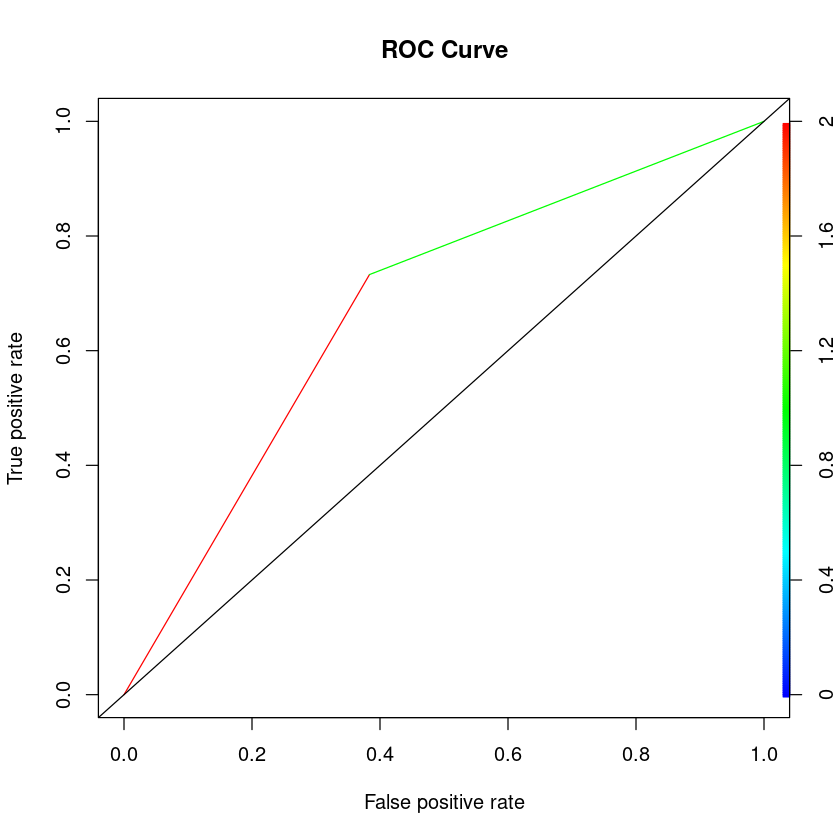

In [21]:
modelPerformance(helaSmoteTreeAlt, "RF", test, Class)

We are assuming "Hub" as a demarcation for the positive class, and so sensitivity of the model being still lower than the specificity establishes that the model is more comprehensible for the "Non-Hub" (negative class). This can again be attributed to the share of data for the respective classes. Ideally, both values be as high in magnitude, is reminiscent of a good model.  

This model is rated lesser in terms of accuracy than the previous model, and the AUC has grown infinitesimally.

#### <a id=link7>1.3.2 'rpart' Package </a>

Using another package, we shall continue to work on the SMOTE transformed training data to model the classifier.

In [22]:
helaTreeAlt <- rpart(Class ~ ., data = smoteData)

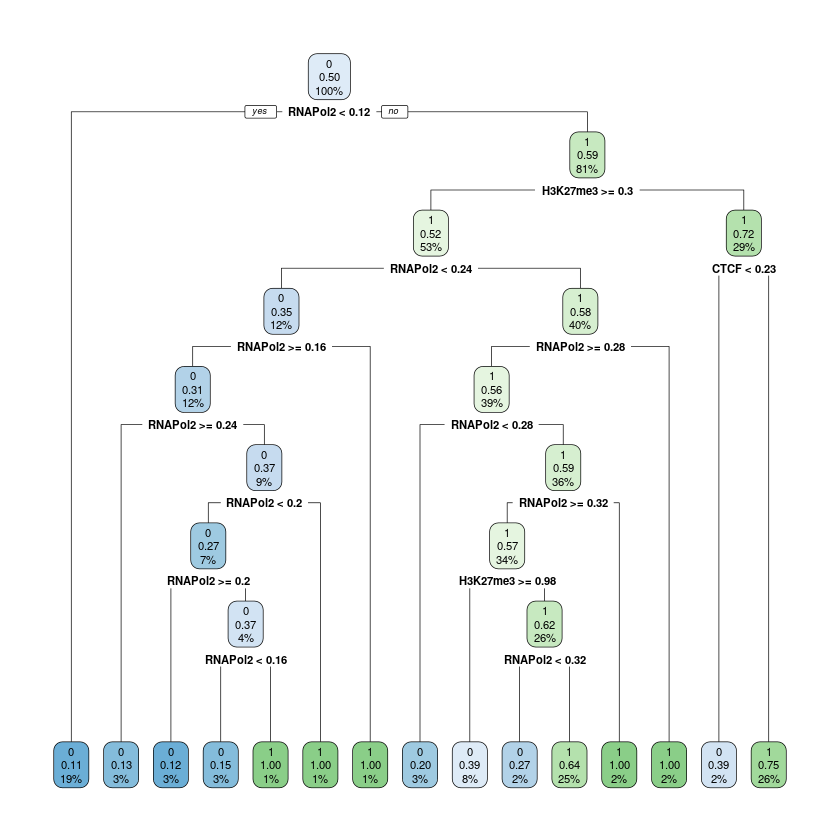

In [23]:
rpart.plot(helaTreeAlt)

There is a complete contrast between the two trees drawn from *ctree()* and *rpart()* functions. The *ctree* uses a significance test procedure in order to select variables instead of selecting the variable that maximizes an information measure (e.g. Gini coefficient). Basically the methodology of both approaches is different; *rpart* is a CART algorithm, while *party* is a CHAID algorithm. (http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html).

Next, we move to the more fuller concept, of Random Forests.

##  <a id=link8>2. Random Forests </a>

<p align="justify"> Decision trees are accomodated inside Random Forests. This ensemble brings about variety in data classification and hence more robustness. This notion also helps in avoidance of overfitting. Random forests can deal with large number of features and selects them for constructing trees on the basis of importance. As we will see, they are easy to implement and have two free parameters to tune- (i) *ntree* signifying the number of trees (where default value is 500), and (ii) *mtry* denoting variables randomly selected for each split (default here sq(p) when classification is sought, and (p/3) when regression; p is the total number of features in the dataset). </p>

###  <a id=link9>2.1 Core (randomForest) </a>

There are basically three steps involved in construction of a Random Forest:
    1. Draw *ntree* bootstrap samples.
    2. For each bootstrap sample, grow a un-pruned tree by choosing best split based on a random sample of *mtry* predictors at each node.
    3. Predict new data using majority votes for classification, and average for regression based on *ntree* trees.

For application, we shall consider a subset of the data we used for decision trees. The random forests algorithm tend to consume greater in terms of computational resources.

Moving away from the Pareto's principle, let us work with 70:30 split for training and testing data.

In [24]:
## Let us work with a fraction (10%) of data. The algorithm, given the computational resources, fails in execution for the whole data. 

set.seed(8)
helagregSample <- helagreg[sample(nrow(helagreg), replace=T, size=0.1*nrow(helagreg)),]

## Making thr response variable a 'factor', since we are attempting classification.

helagregSample$Class <- as.factor(helagregSample$Class)

## failing to which a warning is thrown : Warning message in randomForest.default(m, y, ...):
## “The response has five or fewer unique values.  Are you sure you want to do regression?”

dataPartition73 <- sample(2, nrow(helagregSample), replace = TRUE, prob = c(0.7,0.3))

train73 <- helagregSample[dataPartition73 == 1,]
test73 <- helagregSample[dataPartition73 == 2,]

Again, the data being biased towards the negative classes, that far outnumber the instances with positive class, we shall transform the data towards being relatively heterogeneous.

In [25]:
bothTrain <- ovun.sample(Class ~., data = train73, method = "both", p =0.5, seed = 11)$data
table(bothTrain$Class)


    0     1 
52850 53258 

We have regulated the data points on near equal distribution of classes. Let us train the classifier on this data.

In [26]:
# Execute random forest algorithm

helarf <- randomForest(formula = Class ~ ., 
                    data = bothTrain,
                   proximity = FALSE,
                   ntree = 500)
print(helarf)


Call:
 randomForest(formula = Class ~ ., data = bothTrain, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 0%
Confusion matrix:
      0     1 class.error
0 52850     0           0
1     0 53258           0


In [27]:
# Prediction and Confusion Matrix

helaPredRF <- predict(helarf,test73)
confusionMatrix(helaPredRF, test73$Class, positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 45710    60
         1     0    14
                                         
               Accuracy : 0.9987         
                 95% CI : (0.9983, 0.999)
    No Information Rate : 0.9984         
    P-Value [Acc > NIR] : 0.05454        
                                         
                  Kappa : 0.3178         
                                         
 Mcnemar's Test P-Value : 2.599e-14      
                                         
            Sensitivity : 0.1891892      
            Specificity : 1.0000000      
         Pos Pred Value : 1.0000000      
         Neg Pred Value : 0.9986891      
             Prevalence : 0.0016163      
         Detection Rate : 0.0003058      
   Detection Prevalence : 0.0003058      
      Balanced Accuracy : 0.5945946      
                                         
       'Positive' Class : 1              
                                      

Despite the high accuracy of the model at 99.87 %, a suitable prediction-ability for positive class (sensitivity) is quite low as compared to specificity (100 %). 

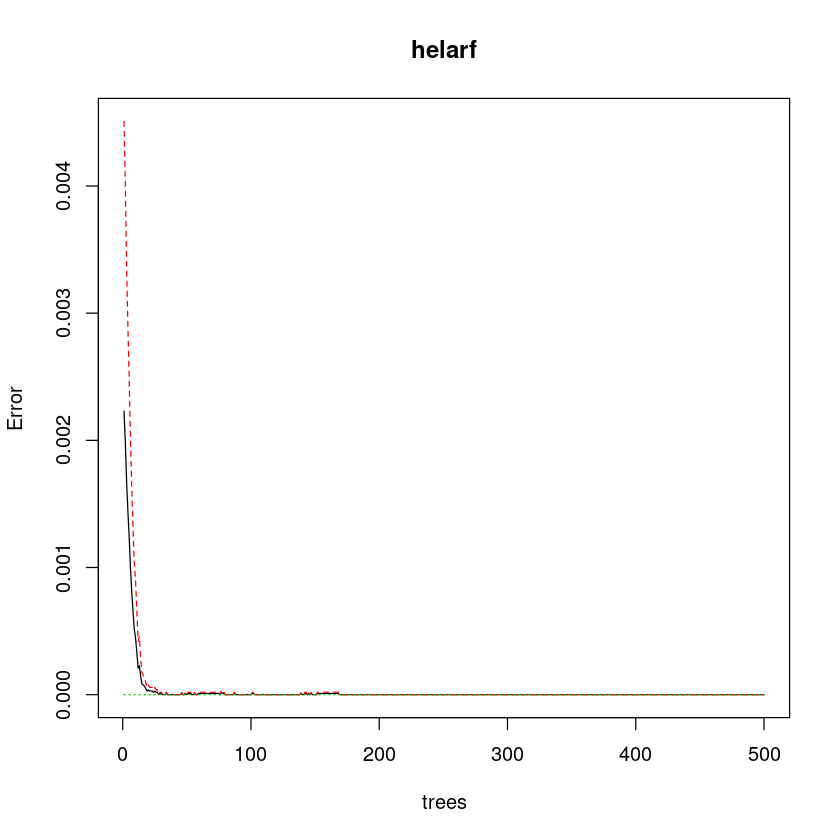

In [28]:
# Error rates (MSEs) of the Random Forest

plot(helarf)

The above plot shows that the error rate stablises after ~ 180 trees and any number of trees beyond doesn't bring any betterment to the error. In view of the same, we shall tune the paramaters of our forest to reduce the number of trees from 500 (default) to 180. Let us observe the change in results. This step helps ascertain an optimal value for *ntree*. 

In [29]:
head(bothTrain)

CTCF      EP300     H3K27me3  H3K36me3  H3K4me1   H3K4me2    H3K4me3   
1 0.8806567 2.6143044 0.6553916 1.3169506 3.2354165 15.8997480 17.8678190
2 0.6720801 0.2614304 1.0335022 0.5365354 0.5046062  0.6246330  0.7878227
3 0.8806567 0.7842913 0.6049769 0.7316392 0.3858754  0.8517722  0.6932840
4 0.2317518 0.1742870 0.4537327 0.3414316 0.2077790  0.4258861  0.2836162
5 0.4403284 0.7842913 0.0000000 0.0000000 0.8014334  0.0000000  0.6302582
6 0.2781021 0.4792891 0.6553916 0.7072512 0.2671445  0.5110633  0.2521033
  H3K9ac     H3K9me3   RAD21     RNA.Seq   RNAPol2     RNAPol3   Class
1 14.4576160 0.5930333 1.5732660 0.1436135 32.93814039 1.1149699 0    
2  1.0233158 1.2972603 0.7429312 0.0000000  0.15854701 0.4512973 0    
3  0.4985385 2.1126810 0.6118257 0.0000000  0.15854701 0.5840318 0    
4  0.2099109 0.5930333 0.2622110 0.0000000  0.19818376 0.7167664 0    
5  0.7609272 0.0000000 0.3933165 0.0000000  0.03963675 0.6636725 0    
6  0.3673441 1.0378082 0.3933165 0.0000000  0.07927350 0.5043911 0

mtry = 3  OOB error = 0% 
Searching left ...
mtry = 2 	OOB error = 0% 
-Inf 0.005 
Searching right ...
mtry = 6 	OOB error = 0% 
-Inf 0.005 


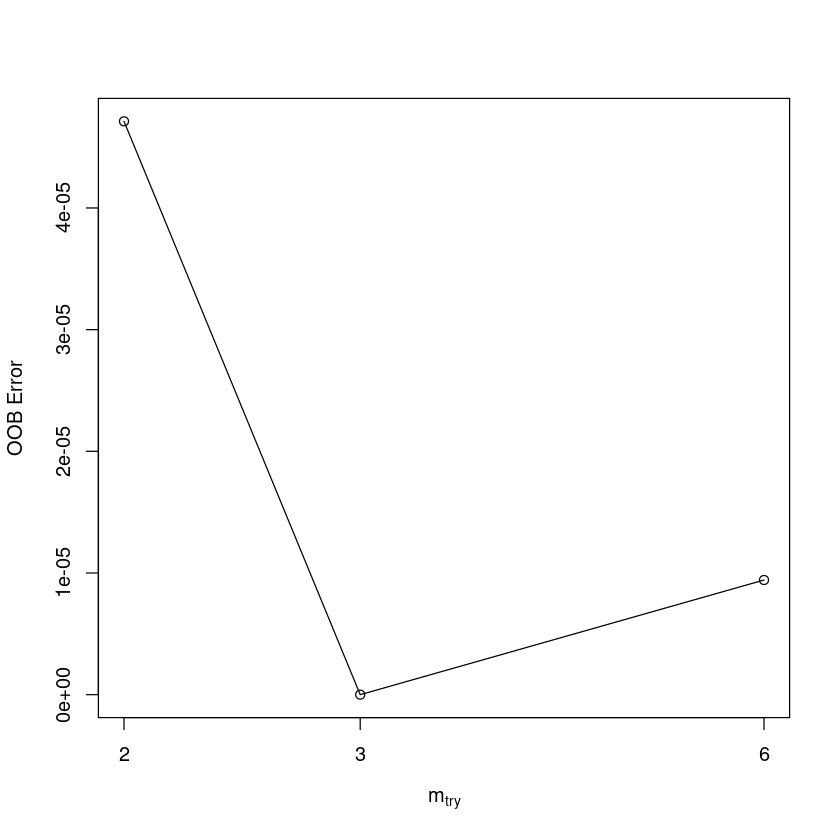

In [30]:
# Tuning mtry

t2 <- tuneRF(bothTrain[,-14], bothTrain[,14],
            stepFactor = 2,
            plot = TRUE,
            ntreeTry = 180,
            trace = TRUE,
            improve = 0.005)               

I think we are good at *mtry* = 3; there is no error.

However, owing to the biasness in the model to predict negative class over positive class, let's make an attempt with *smoteData* flavor and examine any improvement; we did consider balanced samples in *bothTrain* though.

In [31]:
# Execute random forest algorithm

helarf1 <- randomForest(formula = Class ~ ., 
                    data = smoteData,
                   proximity = FALSE,
                   ntree = 180)
print(helarf1)


Call:
 randomForest(formula = Class ~ ., data = smoteData, proximity = FALSE,      ntree = 180) 
               Type of random forest: classification
                     Number of trees: 180
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.8%
Confusion matrix:
      0     1 class.error
0 19654   608  0.03000691
1   525 19737  0.02591057


The confusion matrix is
         Actual
Predicted      0      1
        0 295502    250
        1   8409    214
The accuracy of the model is 97.15515 % 
The misclassification error of the model is 2.844846 % 
The sensitivity of the model is 97.23307 % 
The specificity of the model is 46.12069 % 
The area under curve is 0.7167688 



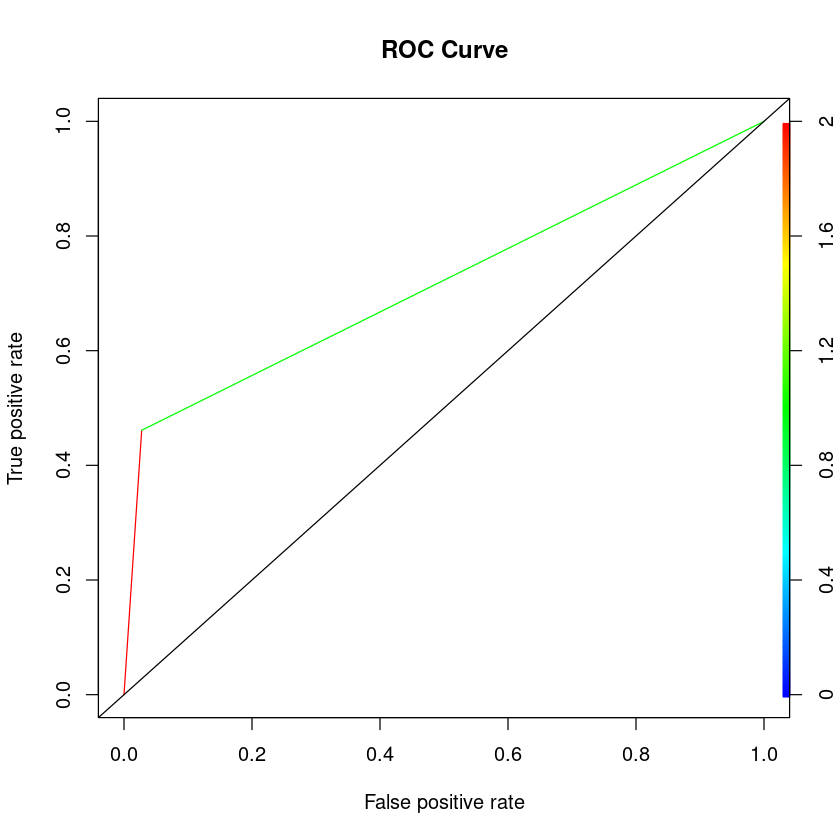

In [32]:
modelPerformance(helarf1, "rf", test, Class)

For sure, this is way better than the previous one, with given improved estimate of sensitivity. We can observe the SMOTE transformation has a positive effect on the model's performance in making predictions for the minority class instances.

In [33]:
helaPredRFOpt <- predict(helarf1,test73)
confusionMatrix(helaPredRFOpt, test73$Class, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 44457     9
         1  1253    65
                                          
               Accuracy : 0.9724          
                 95% CI : (0.9709, 0.9739)
    No Information Rate : 0.9984          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0906          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.878378        
            Specificity : 0.972588        
         Pos Pred Value : 0.049317        
         Neg Pred Value : 0.999798        
             Prevalence : 0.001616        
         Detection Rate : 0.001420        
   Detection Prevalence : 0.028787        
      Balanced Accuracy : 0.925483        
                                          
       'Positive' Class : 1               
                  

The model performs well with the 70:30 data in terms of sensitivity and specificity; although for test data the model was low on sensitivity. Regardless, we'll stick to the model.

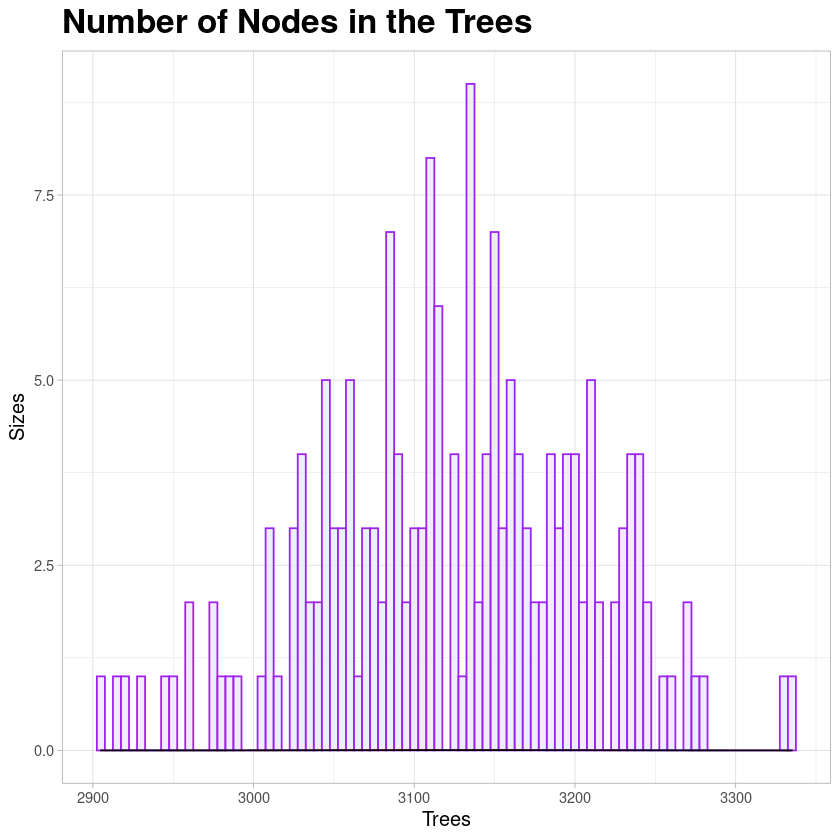

In [34]:
# Number of nodes for the trees

ts <- as.data.frame(treesize(helarf1), row.names = c())
ggplot(data = ts, aes(x = `treesize(helarf1)`)) + 
  geom_histogram(binwidth = 5, color="purple", fill="lavender", position="identity", alpha=0.7)+
  labs(x="Trees", y="Sizes")+
  ggtitle("Number of Nodes in the Trees")+
  geom_density(alpha=0.6)+
  theme_light()+
  theme(plot.title= element_text(size = 20, face = "bold"),
        axis.title = element_text(size = 12))

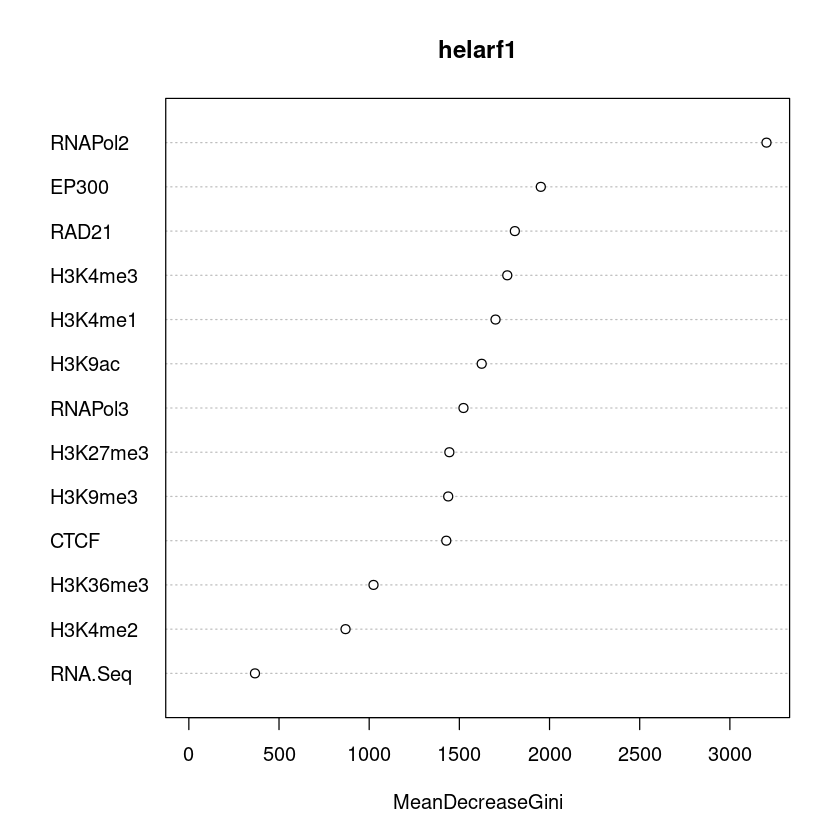

In [35]:
# Variable Importance

varImpPlot(helarf1)

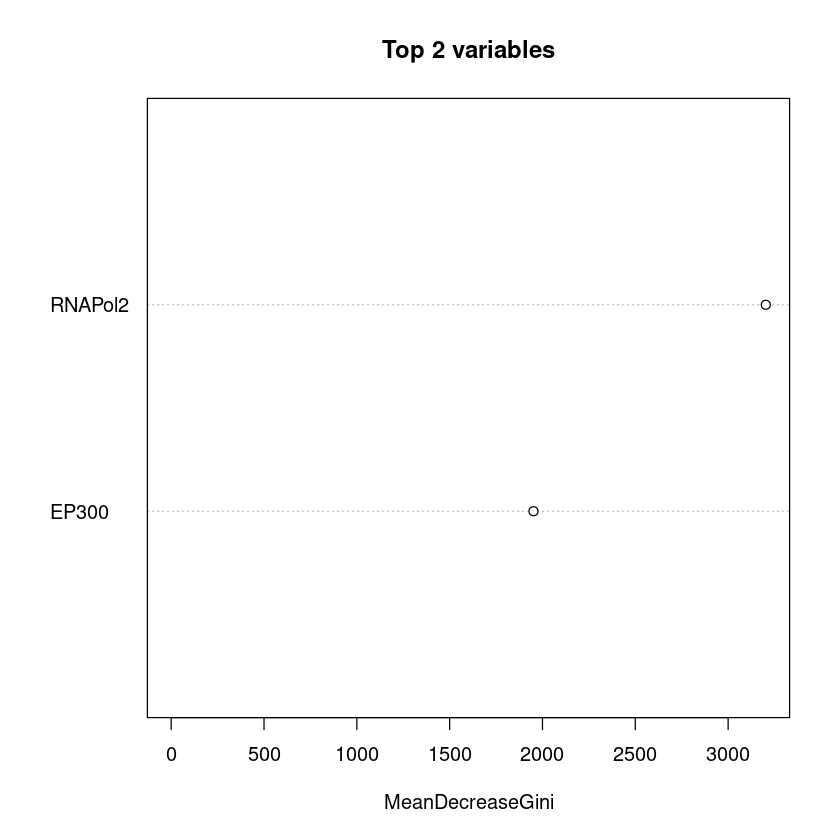

In [36]:
varImpPlot(helarf1 , sort = TRUE, n.var = 2, main = "Top 2 variables")

In [37]:
importance(helarf1)

MeanDecreaseGini
CTCF     1427.5353       
EP300    1951.6385       
H3K27me3 1444.5153       
H3K36me3 1023.9938       
H3K4me1  1700.5627       
H3K4me2   868.9031       
H3K4me3  1765.6724       
H3K9ac   1623.8974       
H3K9me3  1438.1548       
RAD21    1807.6979       
RNA.Seq   366.7055       
RNAPol2  3203.0582       
RNAPol3  1522.8496

In [38]:
varUsed(helarf1)

[1] 51577 51207 35657 34290 51840 31862 50700 50467 41588 50006  9416 50646
[13] 52636

This classification model of random forests projects **RNAPol2** as the most crucial variable with maximum instances used while contruction of trees.

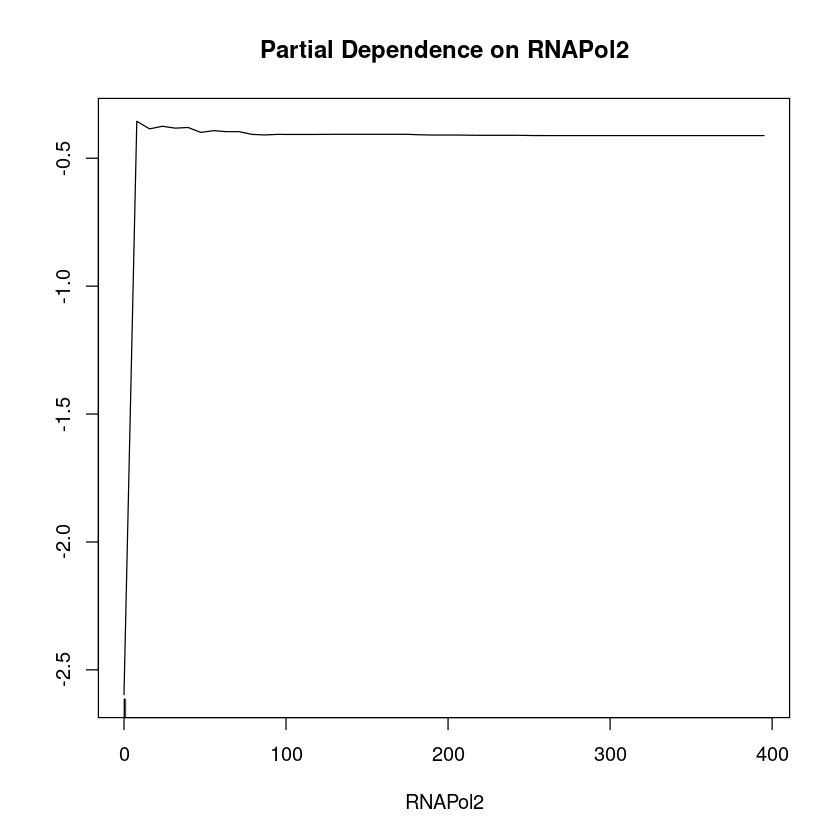

In [39]:
# Partial Dependence Plots

partialPlot(helarf1, smoteData, RNAPol2 , "1")

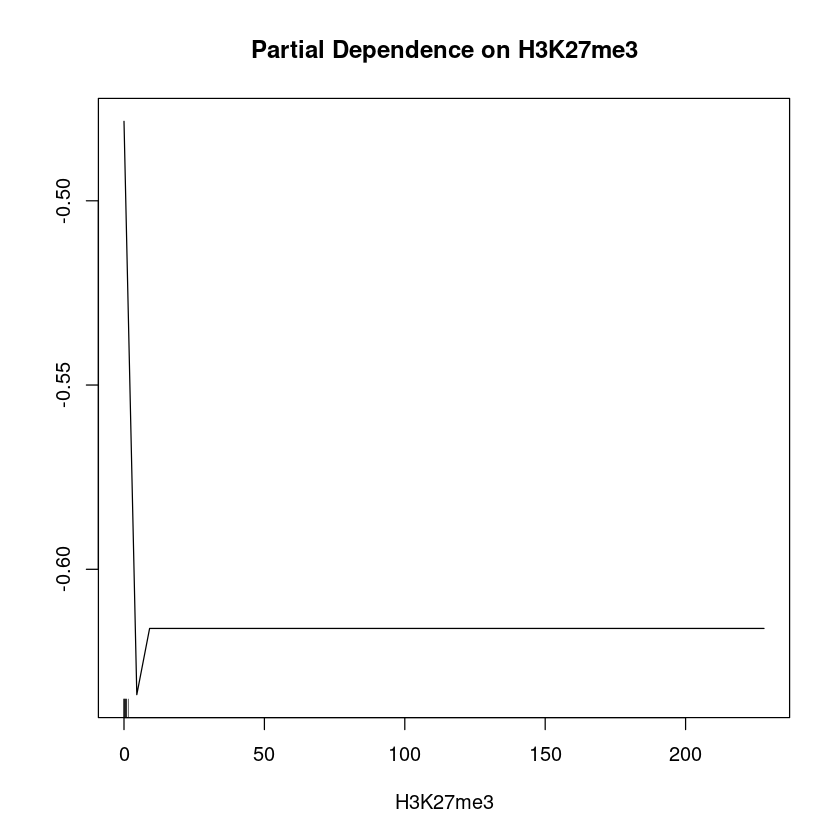

In [40]:
partialPlot(helarf1, smoteData, H3K27me3, "1")

The partial dependence plot represents a variable's contribution to the probability of class depiction (classification). The variable contribution of RNAPol2 is high and regular. Contrarily, as seen above, H3K27me3 has important (stable) contribution to the model but at a much lower scale.

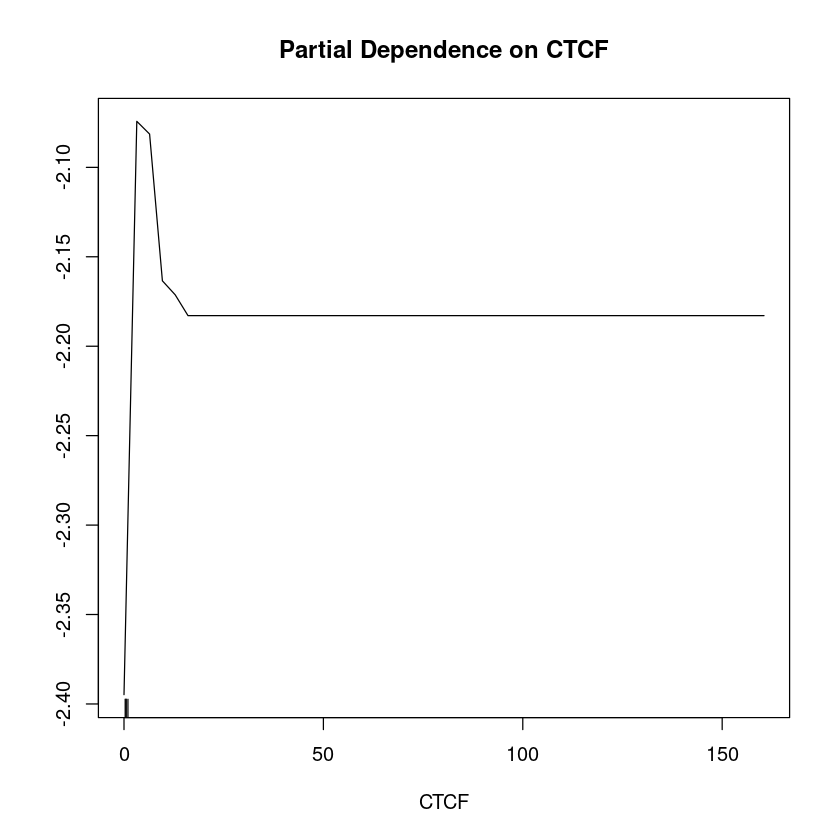

In [41]:
partialPlot(helarf1, smoteData, CTCF, "1")

**CTCF** contributes equally well to the model too.

##  <a id=link10>3. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [42]:
helagregModelPredictions <- predict(helarf1, helagreg, type = "response")
helagregModelPredictionsProbs <- as.factor(helagregModelPredictions)

In [44]:
head(helagregModelPredictionsProbs)

1 2 3 4 5 6 
1 1 1 1 1 1 
Levels: 0 1

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the HeLa cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> is the package we aim to deploy for visualization.

In [43]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

Next, we recall the data from the HeLa cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! 

In [44]:
helagregStandardRegionsClass <- helagregStandard[, c(1:3,17)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [45]:
head(helagregStandardRegionsClass)

chr  start end   Class  
1 chr1     1  2000 Non-Hub
2 chr1  2001  4000 Non-Hub
3 chr1  4001  6000 Non-Hub
4 chr1  6001  8000 Non-Hub
5 chr1  8001 10000 Non-Hub
6 chr1 10001 12000 Non-Hub

In [46]:
## Extracting chr21 data

helagregChr21NonHub <- helagregStandardRegionsClass[helagregStandardRegionsClass$chr=="chr21" & helagregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
helagregChr21Hub <- helagregStandardRegionsClass[helagregStandardRegionsClass$chr=="chr21" & helagregStandardRegionsClass$Class=="Hub", ]

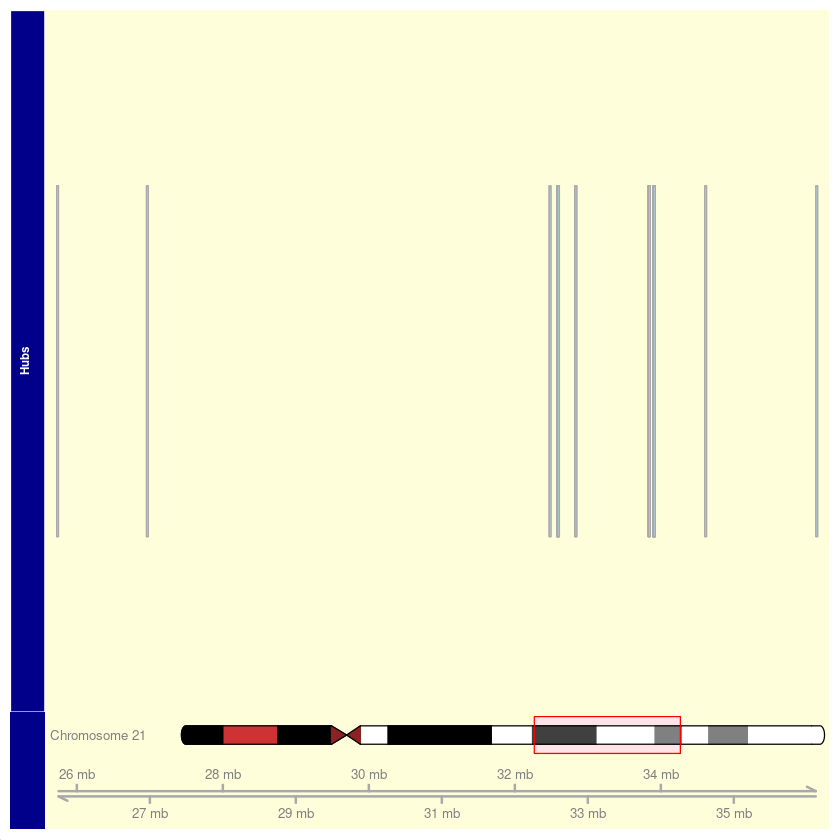

In [47]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = helagregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

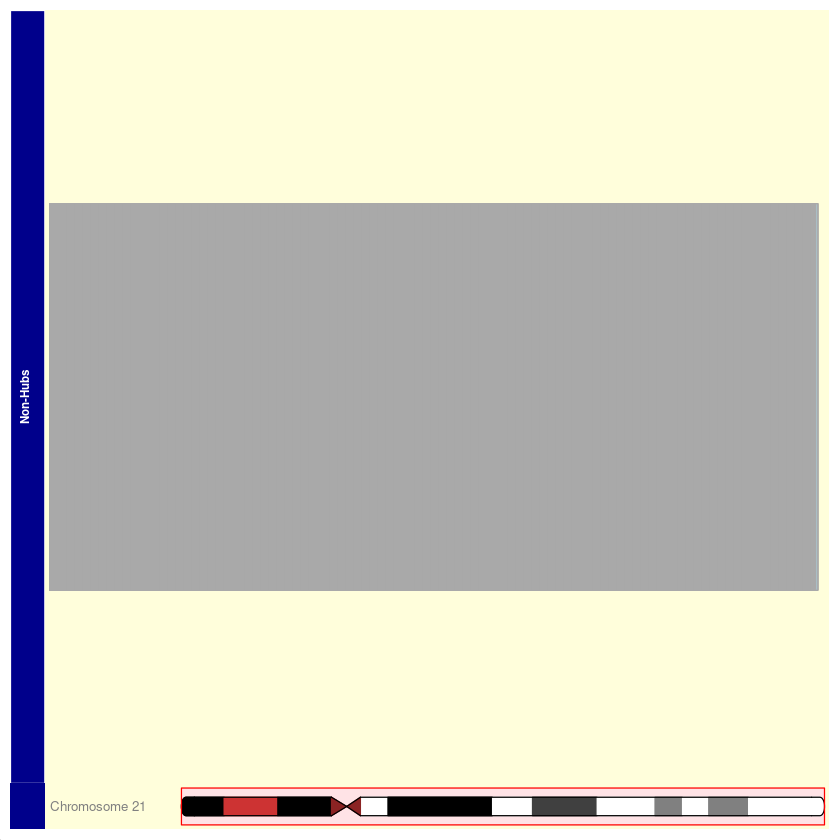

In [48]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = helagregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results. 

In [50]:
helagregPredicted <- cbind(helagregStandardRegionsClass, helagregModelPredictionsProbs)
names(helagregPredicted)[names(helagregPredicted) == "helagregModelPredictionsProbs"] <- "Prediction"
helagregPredicted$Prediction <- ifelse(helagregPredicted$Prediction == 1, "Hub", "Non-Hub")  

Let us see if the classifier predictions match with the original results.

In [51]:
helagregChr21PredicitedHub <- helagregPredicted[helagregPredicted$chr=="chr21" & helagregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

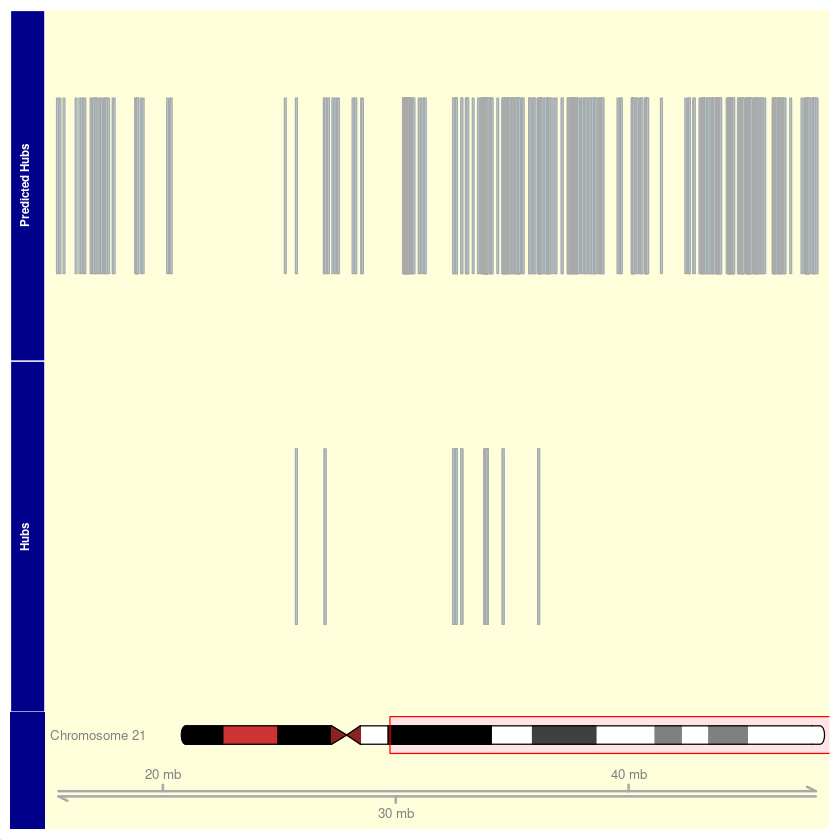

In [52]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = helagregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = helagregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [53]:
truePositives <- helagregPredicted[helagregPredicted$Class == helagregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [54]:
## Saving relevant files

save(helarf1, file = "./optimalModels/helamodelRF") # optimal model
write.table(truePositives, file = "./truePositives/helaRF.txt", quote = FALSE) # true positives: precicted ~ original
write.table(smoteData, file = "./buildData/optimalModelTrainHELARF.txt", quote = FALSE) # data used to train model
write.table(test, file = "./buildData/optimalModelTestHELARF.txt", quote = FALSE) # data used to test model

In [55]:
table(smoteData$Class)


    0     1 
20262 20262 

### Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| helarf1 | 97.15515 % | 97.23307 % | 46.12069 % | Fair

Also, note that data on which the model was trained has a distribution of 20262:20262 = 1 in class proportion. So, the probability of finding any class is 50% (ideally) because we have a homogeneous spread of class labels. Despite since the model has higher sensitivity, i.e. higher knack for predicting positive classes, the performance could be considered fair, despite of higher accuracy. In addition, we observe that the model has a moderate specificity. This symbolises that the negative classes are also marked considerably well.   

##  <a id=link11>4. Session Information </a>

In [56]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          caret_6.0-86         e1071_1.7-3         
[10] ggplot2_3.3.2        ROSE_0.0-3           randomForest_4.6-14 
[13] DMwR_0.4.1           l